## Coregionalized Regression Model (vector-valued regression)
Source: https://nbviewer.org/github/SheffieldML/notebook/blob/master/GPy/coregionalized_regression_tutorial.ipynb

### Setup

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import GPy
GPy.__version__

'1.10.0'

In [17]:
#This functions generate data corresponding to two outputs
f_output1 = lambda x: 4. * np.cos(x/5.) - .4*x - 35. + np.random.rand(x.size)[:,None] * 2.
f_output2 = lambda x: 6. * np.cos(x/5.) + .2*x + 35. + np.random.rand(x.size)[:,None] * 8.


#{X,Y} training set for each output
X1 = np.random.rand(100)[:,None]; X1=X1*75
X2 = np.random.rand(100)[:,None]; X2=X2*70 + 30
Y1 = f_output1(X1)
Y2 = f_output2(X2)
#{X,Y} test set for each output
Xt1 = np.random.rand(100)[:,None]*100
Xt2 = np.random.rand(100)[:,None]*100
Yt1 = f_output1(Xt1)
Yt2 = f_output2(Xt2)

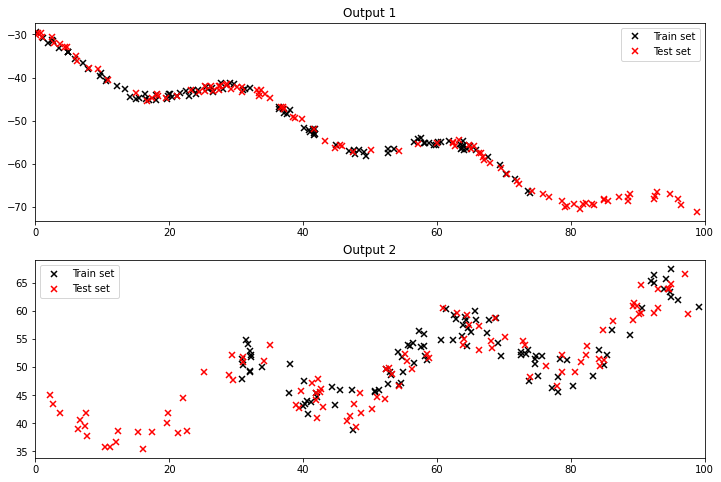

In [18]:
xlim = (0,100); ylim = (0,50)
fig, ax = plt.subplots(2, figsize=(12,8))
# ax[0] = fig.add_subplot(211)
ax[0].set_xlim(xlim)
ax[0].set_title('Output 1')
ax[0].plot(X1[:,:1],Y1,'kx',mew=1.5,label='Train set')
ax[0].plot(Xt1[:,:1],Yt1,'rx',mew=1.5,label='Test set')
ax[0].legend()
# ax2 = fig.add_subplot(212)
ax[1].set_xlim(xlim)
ax[1].set_title('Output 2')
ax[1].plot(X2[:,:1],Y2,'kx',mew=1.5,label='Train set')
ax[1].plot(Xt2[:,:1],Yt2,'rx',mew=1.5,label='Test set')
ax[1].legend()
plt.show()

In [38]:
def plot_2outputs(m,xlim,ylim):   
    # Output 1
    fig, ax = plt.subplots(2, figsize=(12,8))
    ax[0].set_xlim(xlim)
    ax[0].set_title('Output 1')
    m.plot(plot_limits=xlim,fixed_inputs=[(1,0)],which_data_rows=slice(0,100),ax=ax[0])
    ax[0].plot(Xt1[:,:1],Yt1,'rx',mew=1.5)
    ax[0].legend()
    # Output 2
    ax[1].set_xlim(xlim)
    ax[1].set_title('Output 2')
    m.plot(plot_limits=xlim,fixed_inputs=[(1,1)],which_data_rows=slice(100,200),ax=ax[1])
    ax[1].plot(Xt2[:,:1],Yt2,'rx',mew=1.5)
    ax[1].legend()
    plt.show()

### Covariance kernel

In [19]:
K = GPy.kern.RBF(1)
B = GPy.kern.Coregionalize(input_dim=1, output_dim=2)
multkernel = K.prod(B, name="B.K")
print(multkernel)

  B_K.             |   value  |  constraints  |  priors
  rbf.variance     |     1.0  |      +ve      |        
  rbf.lengthscale  |     1.0  |      +ve      |        
  coregion.W       |  (2, 1)  |               |        
  coregion.kappa   |    (2,)  |      +ve      |        


In [21]:
print(B.W)

  index  |  coregion.W  |  constraints  |  priors
  [0 0]  |  0.49140833  |               |        
  [1 0]  |  -1.41991451  |               |        


In [23]:
print(B.B)

[[ 0.74148215 -0.69775782]
 [-0.69775782  2.51615721]]


In [25]:
print(B.kappa)

  index  |  coregion.kappa  |  constraints  |  priors
  [0]    |      0.50000000  |      +ve      |        
  [1]    |      0.50000000  |      +ve      |        


### Intrinsic model of coregionalization (ICM)

In [30]:
icm = GPy.util.multioutput.ICM(input_dim=1, num_outputs=2, kernel=GPy.kern.RBF(1))

In [31]:
print(icm)

  ICM.             |   value  |  constraints  |  priors
  rbf.variance     |     1.0  |      +ve      |        
  rbf.lengthscale  |     1.0  |      +ve      |        
  B.W              |  (2, 1)  |               |        
  B.kappa          |    (2,)  |      +ve      |        


### Coregionalized Regression Model with ICM

In [32]:
K = GPy.kern.Matern32(1)
icm = GPy.util.multioutput.ICM(input_dim=1, num_outputs=2, kernel=K)

m = GPy.models.GPCoregionalizedRegression([X1,X2], [Y1,Y2], kernel=icm)
m['.*Mat32.var'].constrain_fixed(1.) #For this kernel, B.kappa encodes the variance now.
print(m)


Name : gp
Objective : 71720.40276598775
Number of Parameters : 8
Number of Optimization Parameters : 7
Updates : True
Parameters:
  gp.                                    |   value  |  constraints  |  priors
  ICM.Mat32.variance                     |     1.0  |   +ve fixed   |        
  ICM.Mat32.lengthscale                  |     1.0  |      +ve      |        
  ICM.B.W                                |  (2, 1)  |               |        
  ICM.B.kappa                            |    (2,)  |      +ve      |        
  mixed_noise.Gaussian_noise_0.variance  |     1.0  |      +ve      |        
  mixed_noise.Gaussian_noise_1.variance  |     1.0  |      +ve      |        


In [33]:
m.optimize()
print(m)


Name : gp
Objective : 360.4582540740315
Number of Parameters : 8
Number of Optimization Parameters : 7
Updates : True
Parameters:
  gp.                                    |                value  |  constraints  |  priors
  ICM.Mat32.variance                     |                  1.0  |   +ve fixed   |        
  ICM.Mat32.lengthscale                  |   257.23558862640385  |      +ve      |        
  ICM.B.W                                |               (2, 1)  |               |        
  ICM.B.kappa                            |                 (2,)  |      +ve      |        
  mixed_noise.Gaussian_noise_0.variance  |  0.26008183719455913  |      +ve      |        
  mixed_noise.Gaussian_noise_1.variance  |    4.678780595377833  |      +ve      |        


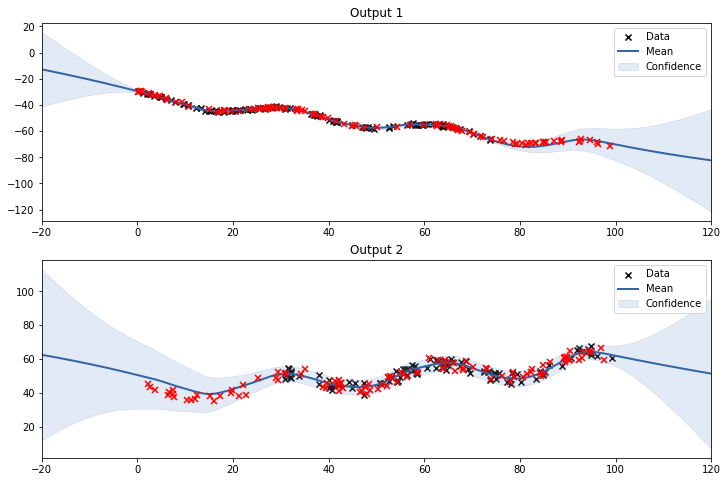

In [39]:
plot_2outputs(m,xlim=(-20,120),ylim=(0,60))

### Coregionalized Regression Model with LCM (more kernels)

In [ ]:
K1 = GPy.kern.Bias(1)
K2 = GPy.kern.Linear(1)

lcm = GPy.util.multioutput.LCM(input_dim=1, num_outputs=2, kernel=lcm)